In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.inspection import permutation_importance
from sklearn.model_selection import KFold
from collections import Counter
import math

In [3]:
import sys
from pathlib import Path

project_root = Path.cwd().parent    
sys.path.append(str(project_root.resolve()))   # now Python can find modules there

import data_preparation   # regular import works

## Import data and transform

In [4]:
df_raw = pd.read_csv("../../Data/Refined/9019/asthma_prevalence_rate.csv")
df_raw

,Measure,Country Name,Disease,Metric,Year,Value,Country Code,Access to clean fuels and technologies for cooking (% of population),Access to electricity (% of population),Carbon dioxide (CO2) emissions excluding LULUCF per capita (t CO2e/capita),...,Oil consumption,u10,v10,d2m,t2m,sst,sp,skt,blh,PM2.5 pollution
0,Prevalence,Japan,Asthma,Rate,1990,5082.997034,JPN,..,100,9.4496485203842,...,1.97956,1.741828,1.021044,288.076401,292.252000,293.810320,102094.635435,293.628495,885.064589,13.37278
1,Prevalence,Japan,Asthma,Rate,1991,5092.603580,JPN,..,100,9.49356587396341,...,2.00120,2.286313,1.311337,288.337128,292.431930,293.870958,101983.583177,293.695755,892.493795,13.29348
2,Prevalence,Japan,Asthma,Rate,1992,5091.760356,JPN,..,100,9.49874382157927,...,2.04296,2.025161,1.717294,288.129279,292.314792,293.702229,102020.582682,293.530340,909.754829,13.22620
3,Prevalence,Japan,Asthma,Rate,1993,5081.664145,JPN,..,100,9.41083802642014,...,1.99111,1.625297,1.286398,287.874186,292.176917,293.652769,102097.751613,293.474290,902.488291,13.17147
4,Prevalence,Japan,Asthma,Rate,1994,5064.407124,JPN,..,100,9.80971896020067,...,2.10148,2.570448,1.109048,288.097394,292.441165,293.978702,102064.984418,293.796735,911.037764,13.12983
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4945,Prevalence,Sudan,Asthma,Rate,2017,4825.147679,SDN,54.1,53,0.554132847201123,...,NaN,-6.390120,-2.174717,294.064998,298.129478,298.260798,101349.605304,299.081299,828.716632,59.81684
4946,Prevalence,Sudan,Asthma,Rate,2018,4814.203984,SDN,56.25,55.3,0.539979158318373,...,NaN,-6.720369,-1.962978,294.571177,298.391357,298.527902,101285.615172,299.362520,809.267977,58.69366
4947,Prevalence,Sudan,Asthma,Rate,2019,4803.510151,SDN,58.9,57.6,0.515394963684055,...,NaN,-6.393558,-1.910857,294.429075,298.369937,298.543588,101300.024220,299.369651,819.350147,51.93562
4948,Prevalence,Sudan,Asthma,Rate,2020,4800.033188,SDN,61,59.7,0.456248148211711,...,NaN,-7.191453,-2.245633,293.988485,297.929028,298.007299,101402.090968,298.836881,847.942231,45.83490


In [50]:
df_raw.columns

Index(['Measure', 'Country Name', 'Disease', 'Metric', 'Year', 'Value',
       'Country Code',
       'Access to clean fuels and technologies for cooking (% of population)',
       'Access to electricity (% of population)',
       'Carbon dioxide (CO2) emissions excluding LULUCF per capita (t CO2e/capita)',
       'Compulsory education, duration (years)', 'GDP (current US$)',
       'GDP per capita (constant 2015 US$)', 'Gini index',
       'Life expectancy at birth, total (years)',
       'Mortality rate, infant (per 1,000 live births)',
       'People using at least basic sanitation services (% of population)',
       'Population, total',
       'Poverty headcount ratio at national poverty lines (% of population)',
       'Renewable electricity output (% of total electricity output)',
       'Surface area (sq. km)',
       'Unemployment, total (% of total labor force) (national estimate)',
       'CO2 emissions', 'Coal consumption', 'Energy use', 'Electricity use',
       'Raw materi

In [5]:
columns_to_keep = [col for col in df_raw.columns if col not in ['Country Name', 'Measure', 'Metric', 'Disease']]
df_excluded = df_raw[columns_to_keep]

In [6]:
df_prepared = data_preparation.preprocessing(df_excluded)

## Hist Gradient Boosting Regressor (not using imputed data)

HistGradientBoostingRegressor (from sklearn.ensemble) is a tree-based model. Tree-based models split data based on thresholds, not on absolute magnitudes, so scaling does not affect them.
Therefore we can avoid to normalize our features.

In [38]:
def country_kfold_splits(countries, k=5, random_state=None):
    """
    Generate train/test splits by countries for K-fold CV.
    Returns a list of tuples: (train_countries, test_countries)
    """
    countries = np.array(countries)
    if random_state is not None:
        np.random.seed(random_state)
    np.random.shuffle(countries)
    
    folds = np.array_split(countries, k)  # split into k roughly equal folds
    
    splits = []
    for i in range(k):
        test_countries = folds[i]
        train_countries = np.hstack([folds[j] for j in range(k) if j != i])
        splits.append((train_countries, test_countries))
    return splits


In [58]:
def train_test_all_years_per_iteration(df, train_columns, target, excluded_columns, n_iterations):
    countries = df['Country Code'].unique()
    
    # Store metrics for all years
    all_train_mse = {}
    all_train_r2 = {}
    all_test_mse = {}
    all_test_r2 = {}
    
    # feature score counter (across all iterations & all years)
    feature_scores = Counter()

    for i in range(n_iterations):
        print(f"Iteration {i} starts") 
        train_mse_list = []
        train_r2_list = []
        mse_list = []
        r2_list = []
        importances_per_year = []

        splits = country_kfold_splits(countries, k=5)

        for j, (train_countries, test_countries) in enumerate(splits):
            print(f"Sub-iteration {j}: Train {len(train_countries)} countries, Test {len(test_countries)} countries")
            
            df_train = df[df["Country Code"].isin(train_countries)]
            df_test = df[df["Country Code"].isin(test_countries)]
            
            # X_train, y_train, X_test, y_test
            features = [c for c in train_columns if c not in excluded_columns]
            X_train = df_train[features]
            y_train = df_train[target]
            X_test = df_test[features]
            y_test = df_test[target]
    
            model = HistGradientBoostingRegressor()
            model.fit(X_train, y_train)
            
            y_train_pred = model.predict(X_train)
            train_mse_list.append(mean_squared_error(y_train, y_train_pred))
            train_r2_list.append(r2_score(y_train, y_train_pred))
    
            y_pred = model.predict(X_test)
            mse_list.append(mean_squared_error(y_test, y_pred))
            r2_list.append(r2_score(y_test, y_pred))
    
            # Permutation importance
            perm = permutation_importance(
                model,
                X_train,
                y_train,
                n_repeats=3,      
                random_state=42,
                n_jobs=-1         # use all CPU cores
            )
            
            perm_importances = pd.Series(perm.importances_mean, index=X_train.columns)

            # Take top 5 features of the year
            top_5 = perm_importances.sort_values(ascending=False).head(5)

            # Update feature score counter
            feature_scores.update(top_5.index)
    
        # Store averaged metrics for this iteration
        all_train_mse[i] = np.mean(train_mse_list)
        all_train_r2[i] = np.mean(train_r2_list)
        all_test_mse[i] = np.mean(mse_list)
        all_test_r2[i] = np.mean(r2_list)
            
        print(f"Iteration {i} done\n")   

    # ============================================================
    # PLOT: MSE & R2 per iteration
    # ============================================================
    
    # Prepare data
    mean_train_mse_values = [np.mean(mse_list) for i, mse_list in all_train_mse.items()]
    mean_test_mse_values = [np.mean(mse_list) for i, mse_list in all_test_mse.items()]
    mean_train_r2_values = [np.mean(r2_list) for i, r2_list in all_train_r2.items()]
    mean_test_r2_values = [np.mean(r2_list) for i, r2_list in all_test_r2.items()]
    sorted_iterations = range(n_iterations)
    
    # Create plots
    fig, axs = plt.subplots(2, 1, figsize=(10, 6), sharex=True)
    
    # MSE plot
    axs[0].plot(sorted_iterations, mean_train_mse_values, marker='o', linestyle='--', color='orange', label='Train MSE')
    axs[0].plot(sorted_iterations, mean_test_mse_values, marker='o', linestyle='-', color='orange', label='Test MSE')
    axs[0].set_title('Mean MSE per Year')
    axs[0].set_ylabel('Mean Squared Error')
    axs[0].legend()
    axs[0].grid(True)
    
    # R² plot
    axs[1].plot(sorted_iterations, mean_train_r2_values, marker='s', linestyle='--', color='blue', label='Train R²')
    axs[1].plot(sorted_iterations, mean_test_r2_values, marker='s', linestyle='-', color='blue', label='Test R²')
    axs[1].set_title('Mean R² Score per Year')
    axs[1].set_ylabel('R² Score')
    axs[1].set_xlabel('Iteration')
    axs[1].legend()
    axs[1].grid(True)
    
    # Labels and legend
    plt.tight_layout()
    plt.show()

    global_mean_r2_test = np.mean(mean_test_r2_values)
    print(f"Mean R2 value (test): {global_mean_r2_test}")   
    
    # ============================================================
    #  PLOT: Top 6 Most Important Features Across All Iterations
    # ============================================================

    top6 = feature_scores.most_common(6)
    feat_names = [f for f, s in top6]
    feat_scores = [s for f, s in top6]

    plt.figure(figsize=(10, 4))
    plt.barh(feat_names, feat_scores)
    plt.xlabel("Frequency Appearing in Top 5")
    plt.title("Top 6 Most Important Features (Across All Iterations)")
    plt.gca().invert_yaxis()
    plt.grid(axis='x', linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()

Iteration 0 starts
Sub-iteration 0: Train 131 countries, Test 33 countries
Sub-iteration 1: Train 131 countries, Test 33 countries
Sub-iteration 2: Train 131 countries, Test 33 countries
Sub-iteration 3: Train 131 countries, Test 33 countries
Sub-iteration 4: Train 132 countries, Test 32 countries
Iteration 0 done

Iteration 1 starts
Sub-iteration 0: Train 131 countries, Test 33 countries
Sub-iteration 1: Train 131 countries, Test 33 countries
Sub-iteration 2: Train 131 countries, Test 33 countries
Sub-iteration 3: Train 131 countries, Test 33 countries
Sub-iteration 4: Train 132 countries, Test 32 countries
Iteration 1 done

Iteration 2 starts
Sub-iteration 0: Train 131 countries, Test 33 countries
Sub-iteration 1: Train 131 countries, Test 33 countries
Sub-iteration 2: Train 131 countries, Test 33 countries
Sub-iteration 3: Train 131 countries, Test 33 countries
Sub-iteration 4: Train 132 countries, Test 32 countries
Iteration 2 done

Iteration 3 starts
Sub-iteration 0: Train 131 cou

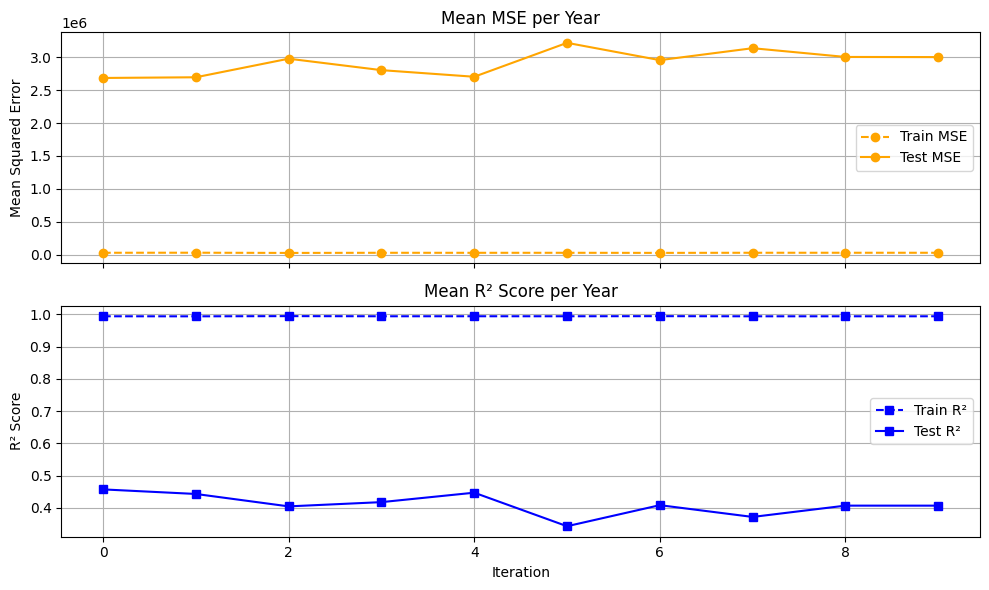

Mean R2 value (test): 0.4104513298211561


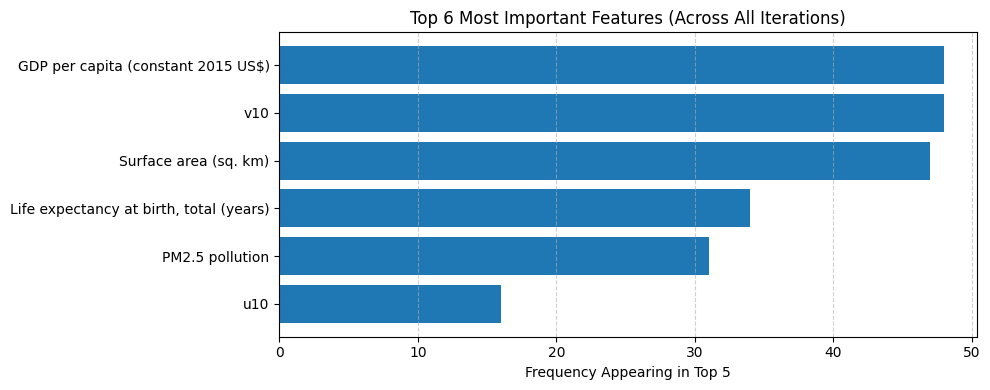

In [55]:
train_test_all_years_per_iteration(df_prepared, df_prepared.columns, "Value", ["Value", "Country Code", "Year"], 10)

Iteration 0 starts
Sub-iteration 0: Train 131 countries, Test 33 countries
Sub-iteration 1: Train 131 countries, Test 33 countries
Sub-iteration 2: Train 131 countries, Test 33 countries
Sub-iteration 3: Train 131 countries, Test 33 countries
Sub-iteration 4: Train 132 countries, Test 32 countries
Iteration 0 done

Iteration 1 starts
Sub-iteration 0: Train 131 countries, Test 33 countries
Sub-iteration 1: Train 131 countries, Test 33 countries
Sub-iteration 2: Train 131 countries, Test 33 countries
Sub-iteration 3: Train 131 countries, Test 33 countries
Sub-iteration 4: Train 132 countries, Test 32 countries
Iteration 1 done

Iteration 2 starts
Sub-iteration 0: Train 131 countries, Test 33 countries
Sub-iteration 1: Train 131 countries, Test 33 countries
Sub-iteration 2: Train 131 countries, Test 33 countries
Sub-iteration 3: Train 131 countries, Test 33 countries
Sub-iteration 4: Train 132 countries, Test 32 countries
Iteration 2 done

Iteration 3 starts
Sub-iteration 0: Train 131 cou

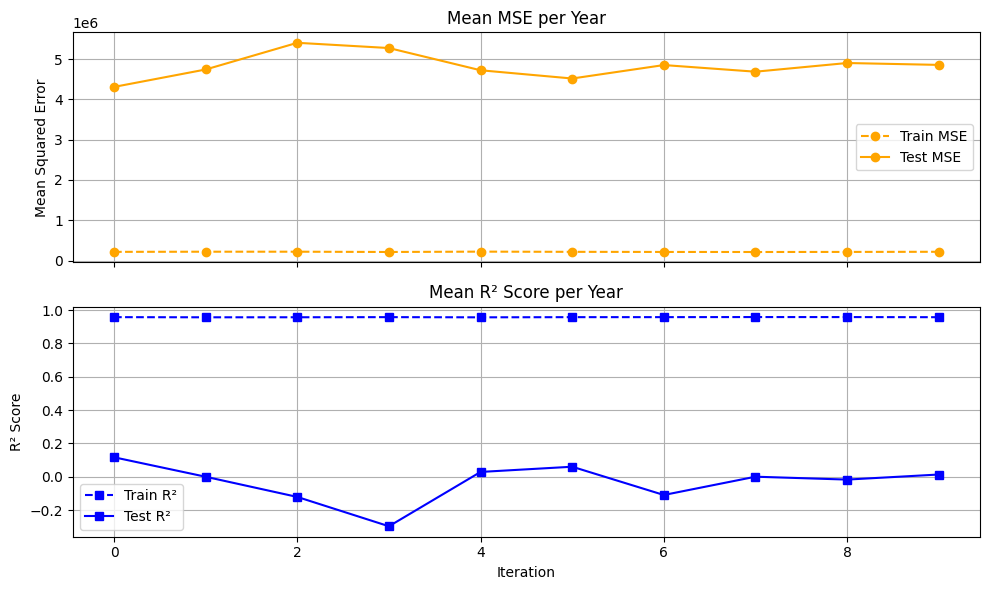

Mean R2 value (test): -0.032095224832661626


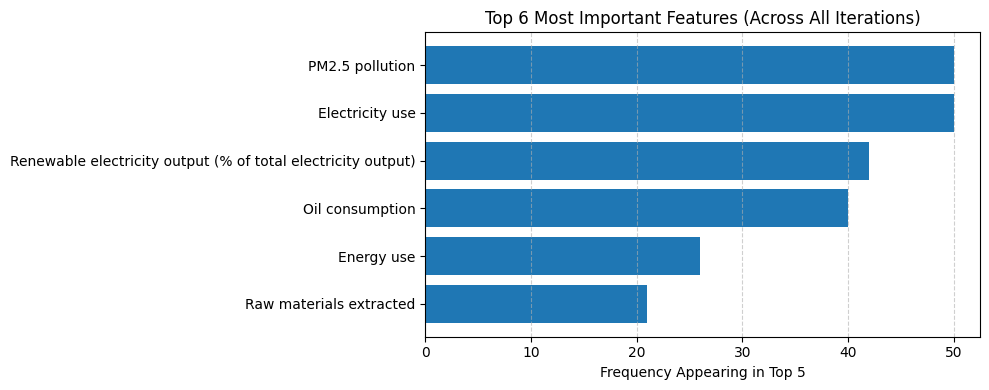

In [56]:
# training only on environmental factors

train_columns= ['Carbon dioxide (CO2) emissions excluding LULUCF per capita (t CO2e/capita)',
       'Renewable electricity output (% of total electricity output)',
       'CO2 emissions', 'Coal consumption', 'Energy use', 'Electricity use',
       'Raw materials extracted', 'Oil consumption', 'PM2.5 pollution']

train_test_all_years_per_iteration(df_prepared, train_columns, "Value", ["Value", "Country Code", "Year"], 10)

## Regression transformation

Here I try to make the problem easier, by transforming the target value.

Iteration 0 starts
Sub-iteration 0: Train 131 countries, Test 33 countries
Sub-iteration 1: Train 131 countries, Test 33 countries
Sub-iteration 2: Train 131 countries, Test 33 countries
Sub-iteration 3: Train 131 countries, Test 33 countries
Sub-iteration 4: Train 132 countries, Test 32 countries
Iteration 0 done

Iteration 1 starts
Sub-iteration 0: Train 131 countries, Test 33 countries
Sub-iteration 1: Train 131 countries, Test 33 countries
Sub-iteration 2: Train 131 countries, Test 33 countries
Sub-iteration 3: Train 131 countries, Test 33 countries
Sub-iteration 4: Train 132 countries, Test 32 countries
Iteration 1 done

Iteration 2 starts
Sub-iteration 0: Train 131 countries, Test 33 countries
Sub-iteration 1: Train 131 countries, Test 33 countries
Sub-iteration 2: Train 131 countries, Test 33 countries
Sub-iteration 3: Train 131 countries, Test 33 countries
Sub-iteration 4: Train 132 countries, Test 32 countries
Iteration 2 done

Iteration 3 starts
Sub-iteration 0: Train 131 cou

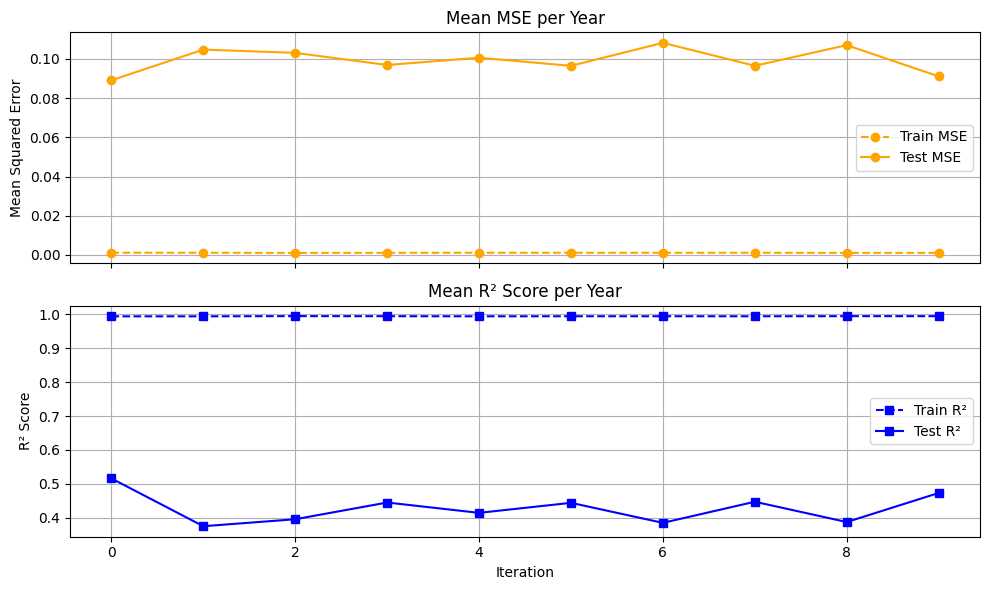

Mean R2 value (test): 0.4284920994672203


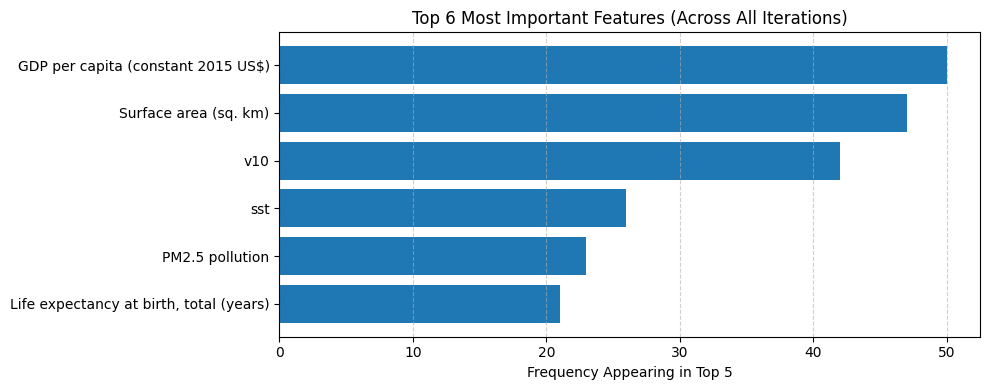

In [59]:
# Log-transform: helps if values vary a lot.
df_prepared['y_log'] = np.log1p(df_prepared['Value'])
train_test_all_years_per_iteration(df_prepared, df_prepared.columns, "y_log", ["y_log", "Value", "Country Code", "Year"], 10)

Iteration 0 starts
Sub-iteration 0: Train 131 countries, Test 33 countries
Sub-iteration 1: Train 131 countries, Test 33 countries
Sub-iteration 2: Train 131 countries, Test 33 countries
Sub-iteration 3: Train 131 countries, Test 33 countries
Sub-iteration 4: Train 132 countries, Test 32 countries
Iteration 0 done

Iteration 1 starts
Sub-iteration 0: Train 131 countries, Test 33 countries
Sub-iteration 1: Train 131 countries, Test 33 countries
Sub-iteration 2: Train 131 countries, Test 33 countries
Sub-iteration 3: Train 131 countries, Test 33 countries
Sub-iteration 4: Train 132 countries, Test 32 countries
Iteration 1 done

Iteration 2 starts
Sub-iteration 0: Train 131 countries, Test 33 countries
Sub-iteration 1: Train 131 countries, Test 33 countries
Sub-iteration 2: Train 131 countries, Test 33 countries
Sub-iteration 3: Train 131 countries, Test 33 countries
Sub-iteration 4: Train 132 countries, Test 32 countries
Iteration 2 done

Iteration 3 starts
Sub-iteration 0: Train 131 cou

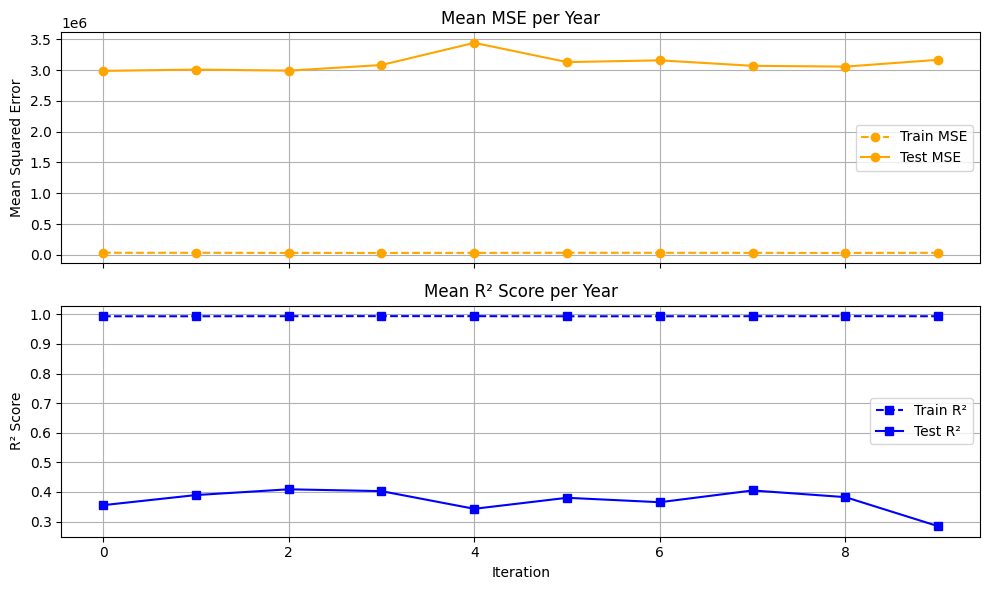

Mean R2 value (test): 0.3717870251576882


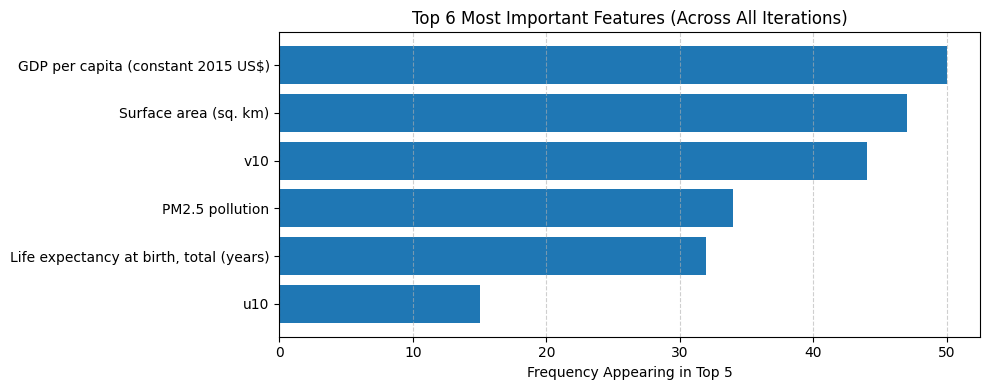

In [60]:
# Relative change / difference: predict change from median value across countries.
df_prepared['y_diff'] = df_prepared['Value'] - df_prepared.groupby('Year')['Value'].transform('median')
train_test_all_years_per_iteration(df_prepared, df_prepared.columns, "y_diff", ["y_diff", "y_log", "Value", "Country Code", "Year"], 10)

Iteration 0 starts
Sub-iteration 0: Train 131 countries, Test 33 countries
Sub-iteration 1: Train 131 countries, Test 33 countries
Sub-iteration 2: Train 131 countries, Test 33 countries
Sub-iteration 3: Train 131 countries, Test 33 countries
Sub-iteration 4: Train 132 countries, Test 32 countries
Iteration 0 done

Iteration 1 starts
Sub-iteration 0: Train 131 countries, Test 33 countries
Sub-iteration 1: Train 131 countries, Test 33 countries
Sub-iteration 2: Train 131 countries, Test 33 countries
Sub-iteration 3: Train 131 countries, Test 33 countries
Sub-iteration 4: Train 132 countries, Test 32 countries
Iteration 1 done

Iteration 2 starts
Sub-iteration 0: Train 131 countries, Test 33 countries
Sub-iteration 1: Train 131 countries, Test 33 countries
Sub-iteration 2: Train 131 countries, Test 33 countries
Sub-iteration 3: Train 131 countries, Test 33 countries
Sub-iteration 4: Train 132 countries, Test 32 countries
Iteration 2 done

Iteration 3 starts
Sub-iteration 0: Train 131 cou

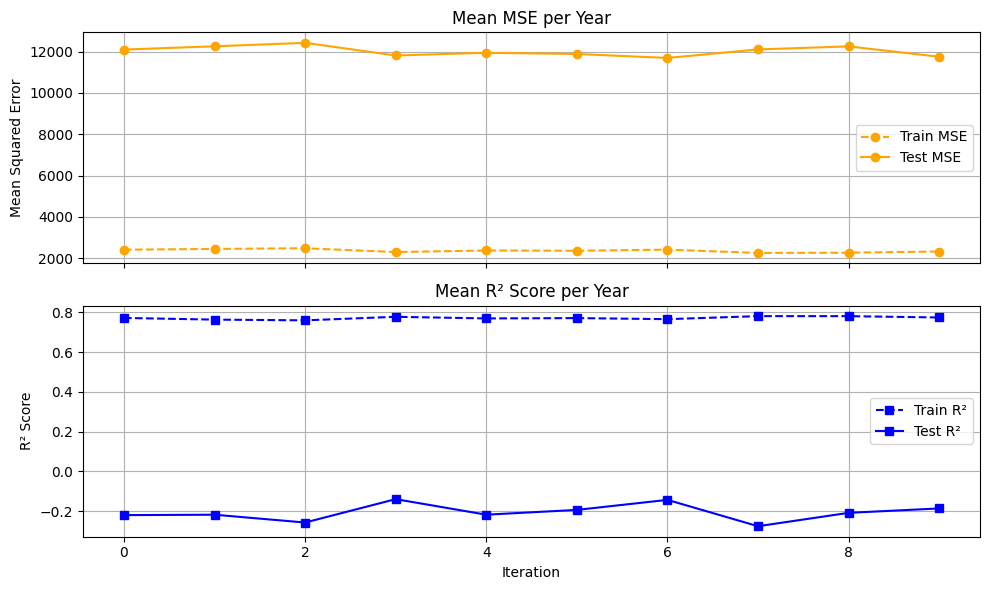

Mean R2 value (test): -0.20636956406485713


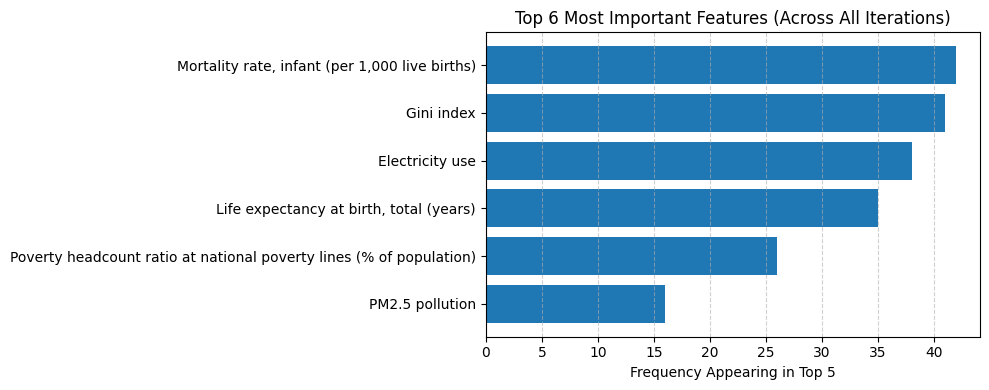

In [61]:
# Relative change / difference: predict change from previous year value (for the same country)
# Sort by country and year
df_prepared = df_prepared.sort_values(['Country Code', 'Year']).reset_index(drop=True)

# Compute change from previous year per country
df_prepared['y_diff_prev_year'] = df_prepared.groupby('Country Code')['Value'].diff()

# Fill NaN (first year for each country) with 0
df_prepared['y_diff_prev_year'] = df_prepared['y_diff_prev_year'].fillna(0)

train_test_all_years_per_iteration(df_prepared, df_prepared.columns, "y_diff_prev_year", ["y_diff_prev_year", "y_diff", "y_log", "Value", "Country Code", "Year"], 10)